/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


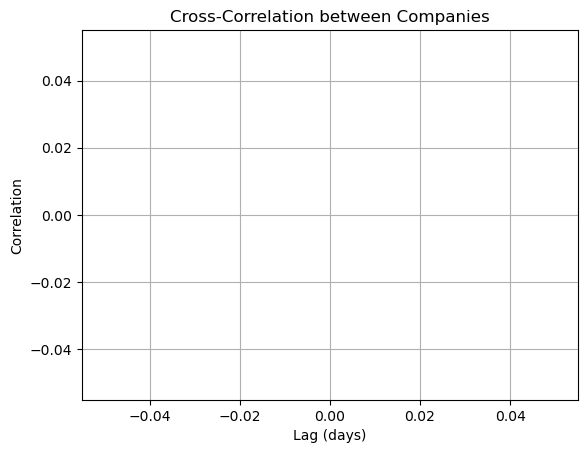

In [7]:
import pandas as pd
import numpy as np
from datetime import datetime

# Загрузка данных
file_path = "/Users/danilalipatov/PycharmProjects/diploma/witn_new_rat_ag_num_cat_catnum_cb.xlsx"
df = pd.read_excel(file_path)

# Преобразование даты в формат datetime
df["_date"] = pd.to_datetime(df["_date"])

# Удаление строк с пропущенными значениями в ключевых столбцах
df = df.dropna(subset=["identifier", "rating_num_cb", "_date", "agency", "_ro_type"])

# Создание мультииндекса для ресемплинга
groups = df.groupby(["identifier", "agency", "_ro_type"])

resampled_data = []
for (identifier, agency, ro_type), group in groups:
    # Установка даты в индекс для ресемплинга
    group = group.set_index("_date")
    group = group[["rating_num_cb"]]
    
    # Ресемплинг по дням с заполнением средним
    daily_data = group.resample("D").mean()
    daily_data["rating_num_cb"] = daily_data["rating_num_cb"].fillna(daily_data["rating_num_cb"].mean())
    
    # Сброс индекса и добавление групповых меток
    daily_data = daily_data.reset_index()
    daily_data["identifier"] = identifier
    daily_data["agency"] = agency
    daily_data["_ro_type"] = ro_type
    
    resampled_data.append(daily_data)

# Объединение всех данных
final_df = pd.concat(resampled_data)

# Функция для вычисления кросс-корреляции между двумя компаниями
def calculate_cross_correlation(df, identifier1, identifier2, agency, ro_type, max_lag=30):
    # Фильтрация данных по условиям
    company1 = df[
        (df["identifier"] == identifier1) & 
        (df["agency"] == agency) & 
        (df["_ro_type"] == ro_type)
    ].set_index("_date")["rating_num_cb"]
    
    company2 = df[
        (df["identifier"] == identifier2) & 
        (df["agency"] == agency) & 
        (df["_ro_type"] == ro_type)
    ].set_index("_date")["rating_num_cb"]
    
    # Выравнивание временных рядов
    aligned_data = pd.DataFrame({"comp1": company1, "comp2": company2}).dropna()
    
    # Вычисление кросс-корреляции
    correlations = []
    for lag in range(-max_lag, max_lag + 1):
        if lag < 0:
            shifted = aligned_data["comp1"].shift(lag)
        else:
            shifted = aligned_data["comp2"].shift(lag)
        
        corr = np.corrcoef(aligned_data["comp1"].dropna(), shifted.dropna())[0, 1]
        correlations.append(corr)
    
    return correlations

# Пример использования
identifier1 = "268008010"  # Пример идентификатора из данных
identifier2 = "1402046014"  # Пример другого идентификатора
agency = "Expert RA"        # Пример агентства
ro_type = "BNFC - нефинансовая компания"  # Пример типа компании

correlations = calculate_cross_correlation(final_df, identifier1, identifier2, agency, ro_type)

# Визуализация
import matplotlib.pyplot as plt

lags = np.arange(-30, 31)
plt.plot(lags, correlations)
plt.xlabel("Lag (days)")
plt.ylabel("Correlation")
plt.title("Cross-Correlation between Companies")
plt.grid(True)
plt.show()

/var/folders/0w/pg719rr9519435t25t6yf2hm0000gn/T/ipykernel_47438/1596805613.py:22: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  pivot_quarterly = pivot_df.resample("A").mean()


Quarterly Correlation Matrix (Spearman) filled with global average:
identifier  0           103001895   106000547   268008010   272901636   \
identifier                                                               
0             1.000000   -0.870388   -0.177980    0.674200   -0.174078   
103001895    -0.870388    1.000000    0.121716   -0.774597    0.200000   
106000547    -0.177980    0.121716    1.000000   -0.377124    0.097373   
268008010     0.674200   -0.774597   -0.377124    1.000000   -0.258199   
272901636    -0.174078    0.200000    0.097373   -0.258199    1.000000   
...                ...         ...         ...         ...         ...   
9729278924   -0.032233    0.185164   -0.123956   -0.478091    0.123443   
9729292044   -0.560612    0.487950   -0.142539   -0.377964    0.097590   
9731004688    0.275211   -0.061999   -0.285814   -0.120060    0.030999   
9731098069    0.560612   -0.487950    0.142539    0.377964   -0.097590   
9731132249   -0.382971    0.333333   -0.0973

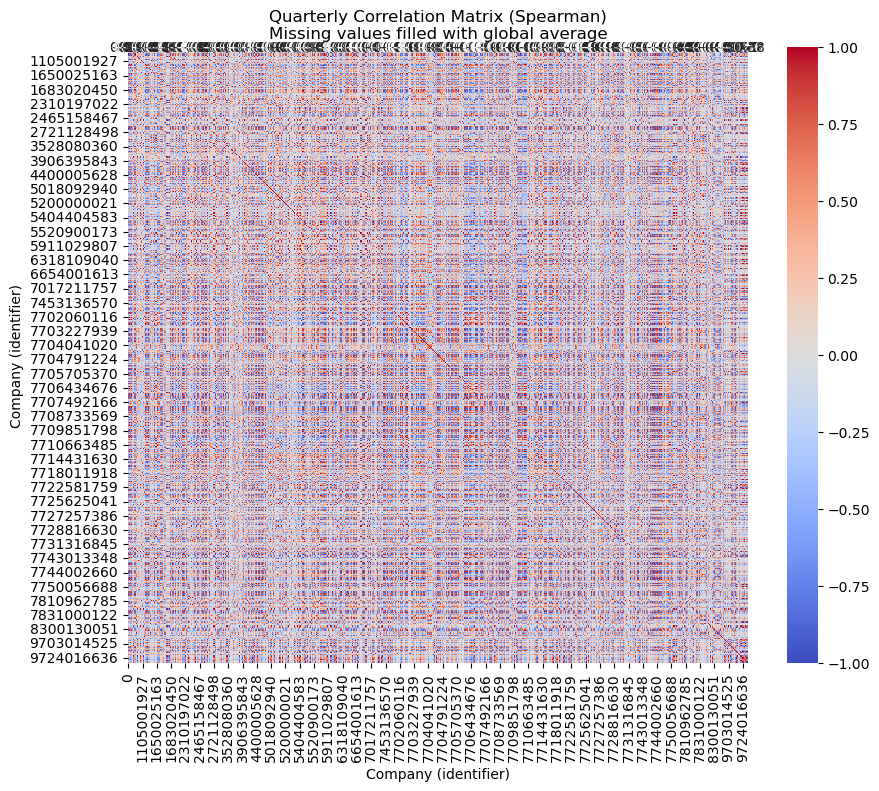

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Шаг 1. Загрузка данных и предобработка
file_path = 'witn_new_rat_ag_num_cat_catnum_cb.xlsx'
df = pd.read_excel(file_path)
df["_date"] = pd.to_datetime(df["_date"])
df = df.dropna(subset=["identifier", "rating_num_cb", "_date", "agency", "_ro_type"])

# Шаг 2. Агрегация по дате (если за один день несколько значений, берём среднее)
df_agg = df.groupby(["identifier", "_date"]).agg({
    "rating_num_cb": "mean",
    "agency": "first",
    "_ro_type": "first"
}).reset_index()

# Шаг 3. Формирование сводной таблицы: строки – даты, столбцы – компании (identifier)
pivot_df = df_agg.pivot(index="_date", columns="identifier", values="rating_num_cb")

# Шаг 4. Ресемплирование по кварталам – агрегируем значения методом среднего
pivot_quarterly = pivot_df.resample("A").mean()

# Шаг 5. Заполнение пропусков: вычисляем глобальное среднее значение и заполняем им NaN
global_avg = pivot_quarterly.stack().mean()
pivot_quarterly = pivot_quarterly.fillna(global_avg)

# Шаг 6. Вычисление корреляционной матрицы (метод Spearman)
corr_matrix = pivot_quarterly.corr(method="spearman")
print("Quarterly Correlation Matrix (Spearman) filled with global average:")
print(corr_matrix)

# Шаг 7. Визуализация корреляционной матрицы через тепловую карту
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Quarterly Correlation Matrix (Spearman)\nMissing values filled with global average")
plt.xlabel("Company (identifier)")
plt.ylabel("Company (identifier)")
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


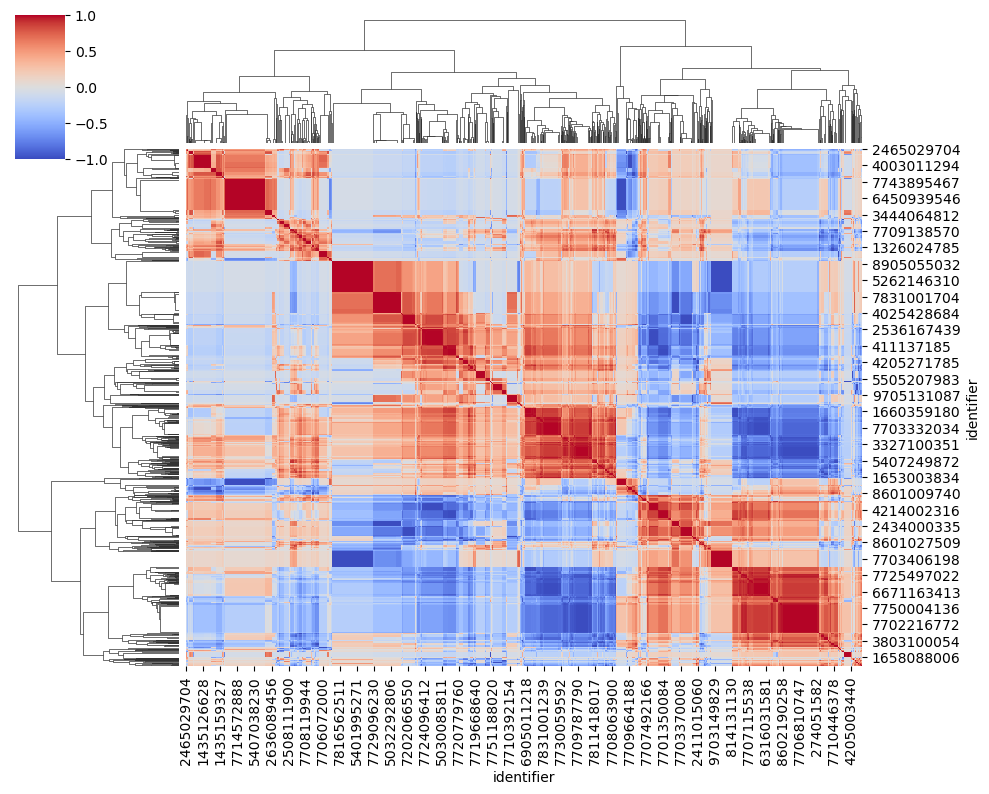

In [34]:
sns.clustermap(corr_matrix, cmap='coolwarm', figsize=(10, 8))
plt.show()